# Load modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.compiler
from pycuda.compiler import SourceModule
import sys
import geebls
import geeblso
import gfilter
import getstat

# Generating Light Curves

In [2]:
import blstest
import batman
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup

nq=4 # # of bacth
n=1024*8 # # of time series

#mock LC
params = batman.TransitParams() 
params.t0 = 1.0 # time of inferior conjunction 
params.rp = R_jup/R_sun # planet radius (in units of stellar radii)

# calculate semi-major axis from orbital period value
params.inc = 90.0  # orbital inclination (in degrees)
params.ecc = 0. # eccentricity
params.w = 90. # longitude of periastron (in degrees), 90 for circular
params.u = [0.1, 0.3] # limb darkening coefficients
params.limb_dark = "quadratic" # limb darkening model
t = np.linspace(0.0, 6.0*12, n) # times at which to calculate the light curve
# seed of gaussian error 
rs = np.random.RandomState(seed=23)    

#generating batch array by "append" method
lc=[]
Ptrue=[]
ntrend=2
for i in range(0,nq):
    #period update
    params.per = rs.rand(1)[0]*5.0 # orbital period (days)
    Ptrue.append(params.per)
    a = (((params.per*u.day)**2 * G * (M_sun + M_jup) / (4*np.pi**2))**(1./3)).to(R_sun).value     
    params.a = a # semi-major axis (in units of stellar radii)
    m = batman.TransitModel(params, t) # initializes the model
    f = m.light_curve(params)
    #adding errors
    errors = 0.002*np.ones_like(f)
    f += errors*rs.randn(len(t))    
    tu=(t-t[0]).astype(np.float32)
    lc_eachx=(f-np.mean(f)).astype(np.float32)
    #adding trends
    phases = rs.rand(ntrend)*2.0*np.pi
    Ptrend = rs.rand(ntrend)*20.0+1.0
    amp = rs.rand(ntrend)*0.02
    for j in range(0,ntrend):
        lc_eachx=lc_eachx+amp[j]*np.sin(2.0*np.pi/Ptrend[j]*t+phases[j])    
    lc.append(lc_eachx)
lc=np.array(lc).transpose().astype(np.float32)
print(Ptrue)

[2.5864894192329464, 1.397283219592943, 2.6550228531286901, 4.5895672160043031]


# Detrend by gfilter

In [3]:
##detrend (directly use)
#lc=np.array(lc,order="C")
nby=512 ## of thread
dev_imgout,dev_avearr=gfilter.get_detrend(lc,nby=nby,nbx=1,r=32,isw=0,osw=1) #detrend

#compute offset (this procedure is inefficient for GPU)
ave1= np.zeros(int(n/nby)*nq).astype(np.float32)
cuda.memcpy_dtoh(ave1, dev_avearr)
ave1 = ave1.reshape((int(n/nby),nq))
offset=(np.sum(ave1,axis=0)/n).astype(np.float32) #average
dev_offset = cuda.mem_alloc(tu.nbytes)
cuda.memcpy_htod(dev_offset,offset)

ydim= 8192 xdim= 4
elapsed_time:0.13897371292114258[sec]


## Load and Plot Detrended LCs (not necessary for analysis)

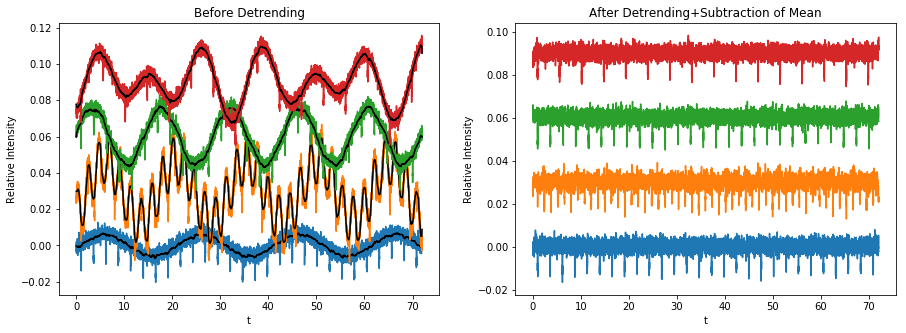

In [4]:
    ##detrend (read from device)
    imgout= np.zeros(nq*n).astype(np.float32)
    cuda.memcpy_dtoh(imgout, dev_imgout)
    
    imgout=imgout.reshape((n,nq))-offset
    #imgout=imgout.reshape((nq,n)).transpose()-offset
    tu=(t-t[0]).astype(np.float32)

    #plot
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(121)
    #plt.xlim(0,5)
    for j in range(0,np.min([nq,5])):
        ax.plot(t, lc[:,j]+0.03*j)
        ax.plot(t, lc[:,j]-imgout[:,j]+0.03*j,c="black")
    plt.title("Before Detrending")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    ax=fig.add_subplot(122)
    #plt.xlim(0,5)
    for j in range(0,np.min([nq,5])):
        ax.plot(tu, imgout[:,j]+0.03*j)
    plt.title("After Detrending+Subtraction of Mean")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    plt.show()

# BLS fitting by gbls

In [7]:
    #gbls setting
    qmi = 0.01
    qma = 0.1
    fmin=2/t[-1]
#    fmin = 0.1 
    df=0.0003
#    df = 0.0005 
    nf = 1024*16 #should be power of 2
    nb = 1024 #binsize in BLS

    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    print(1/freq[-1],1/freq[0])

In [9]:
    #imgout=np.array(imgout,order="F").astype(np.float32)
    #lc=np.copy(imgout)
    #gbls
    start = time.time()
    #dev_lc = cuda.mem_alloc(lc.nbytes)
    #cuda.memcpy_htod(dev_imgout,lc)
    #dev_lc = cuda.mem_alloc(imgout.nbytes)
    #cuda.memcpy_htod(dev_lc,imgout.astype(np.float32))
    dev_tu = cuda.mem_alloc(tu.nbytes)
    cuda.memcpy_htod(dev_tu,tu)
    
    blsp=np.zeros(nf*nq).astype(np.float32)
    dev_blsp = cuda.mem_alloc(blsp.nbytes)
    
    source_module=geeblso.gbls_module()
    nthread=512
    pkernel=source_module.get_function("geebls")
    
    ##compute kma,kmi,kkmi
    kma=int(qma*nb)+1
    kmi=int(qmi*nb)
    kkmi=int(n*qmi)
    sharedsize=int(4*(nb+kma)*2+4*nb)
    pkernel(dev_blsp,dev_imgout,dev_tu,dev_offset,\
            np.uint32(n),np.uint32(nf),np.uint32(nb),\
            np.uint32(kma),np.uint32(kmi),np.uint32(kkmi),\
            np.float32(fmin),np.float32(df),\
            block=(nthread,1,1), grid=(int(nf),int(nq)),shared=sharedsize)
    #cuda.memcpy_dtoh(blsp,dev_blsp)
    #print(blsp)

    elapsed_time = time.time() - start
    print (("gbls :{0}".format(elapsed_time)) + "[sec] for # of batch="+str(nq))

gbls :0.08222150802612305[sec] for # of batch=4


# Extract Statistics

In [10]:
Pest,sde=getstat.get_blsstat(dev_blsp,nf,nq,df,fmin)

In [11]:
print("Period (true)",Ptrue)
print("Period (estimate)",Pest)
print("SDE",sde)

Period (true) [2.5864894192329464, 1.397283219592943, 2.6550228531286901, 4.5895672160043031]
Period (estimate) [2.5868015635778341, 1.3972768626476844, 2.6547889442789296, 4.5876236109695183]
SDE [21.668431405723528, 20.922571356055933, 21.913504126443843, 21.827927248375314]


## Show the BLS spectra (not necessary for analysis)

In [12]:
#load BLS spectra on device
cuda.memcpy_dtoh(blsp,dev_blsp)

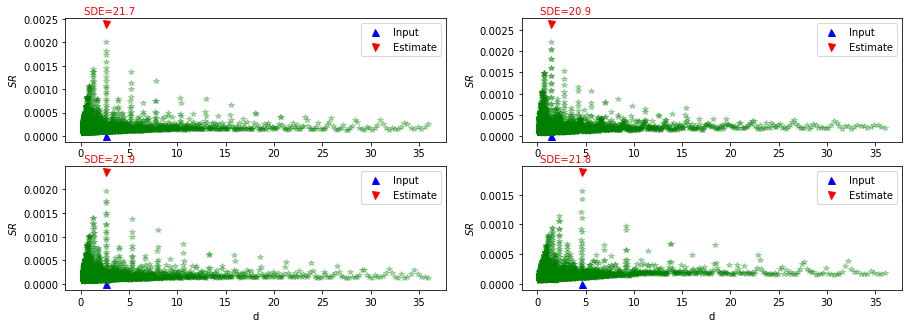

In [13]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    for j in range(0,nq):
        ax=fig.add_subplot(2,2,j+1)
        ax.plot(Ptrue[j],0.0,"^",c="blue",markersize=7,label="Input")
        ax.plot(Pest[j],np.max(blsp[0+j*nf:nf+j*nf])*1.2,"v",c="red",markersize=7,label="Estimate")
        ax.legend()
        ax.plot(1/freq, blsp[0+j*nf:nf+j*nf], 'g*',alpha=0.3)
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.3," SDE="+str(round(sde[j],1)),color="red")
        plt.ylabel(r"$SR$")
        if j>=nq/2:
            plt.xlabel("d")
        #plt.xlim(0.,5)
    plt.show()

# Comparison with Python-bls for one of LCs (not necessary for analysis)

In [14]:
    out1= np.zeros(nq*n).astype(np.float32)
    cuda.memcpy_dtoh(out1, dev_imgout)
    lc = out1.reshape((n,nq))
    #python-bls
    start = time.time()
    ntr, t0, ing, eg, f_1, blsx, nb, bper, bpow, depth, qtran, duration, in1, in2, phase1, phase2=\
    blstest.compute_bls(tu, lc[:,0], df, nf, nb, qmi, qma, fmin)
    #blstest.compute_bls(tu, imgout[:,0], df, nf, nb, qmi, qma, fmin)
        #blstest.compute_bls(tu, lc[:,0], df, nf, nb, qmi, qma, fmin)
    print(blsx)
    elapsed_time = time.time() - start
    print (("python-bls :{0}".format(elapsed_time)) + "[sec] for 1 LC")
    print(len(np.arange(0.3, 0.001*nf+0.3, 0.001)),nf)

Complete
[  2.54732167e-04   1.84019557e-04   1.44448335e-04 ...,   9.05127266e-05
   1.14034554e-04   1.26401765e-04]
python-bls :3.4240565299987793[sec] for 1 LC
16384 16384


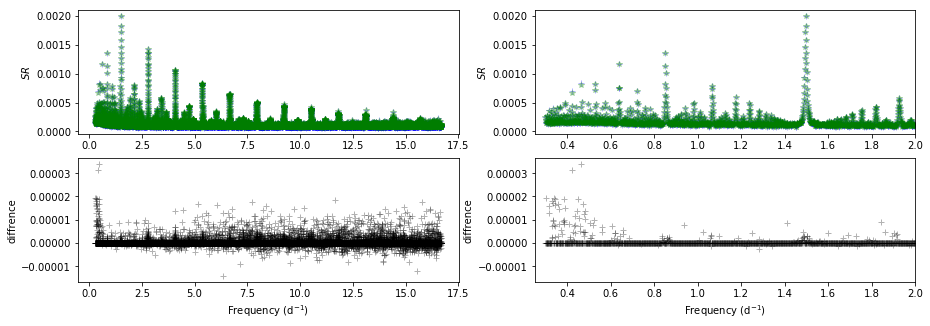

In [15]:
    freq = np.arange(0.3, 0.001*nf+0.3, 0.001)[0:nf]
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(221)
    ax.plot(freq, blsx, 'b+',alpha=0.3)
    ax.plot(freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    ax=fig.add_subplot(222)
    ax.plot(freq, blsx, 'b+',alpha=0.3)
    ax.plot(freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    plt.xlim(0.25,2)
    ax=fig.add_subplot(223)
    ax.plot(freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    ax=fig.add_subplot(224)
    ax.plot(freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    plt.xlim(0.25,2)
    plt.show()